In [102]:
!pip install fancyimpute
!pip install pandas_profiling
!pip install TPOT
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.4 MB/s eta 0:00:00


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import numpy as np
from fancyimpute import KNN
import holidays
from sklearn.model_selection import train_test_split
import tpot
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
import shap

In [17]:
# загружаем таблицы
Pogoda = pd.read_excel('Pogoda.xlsx')
DTP = pd.read_excel('DataDTPкор.xlsx')

In [65]:
# соединяем таблицы
df = Pogoda.merge(DTP, on = 'join_key', how = 'left')

In [66]:
# смотрим объединённую таблицу
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286662 entries, 0 to 286661
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   join_key               286662 non-null  object        
 1   datetime_x             286662 non-null  object        
 2   year                   286662 non-null  int64         
 3   month                  286662 non-null  int64         
 4   region_x               286662 non-null  object        
 5   temperature            286632 non-null  float64       
 6   atmospheric pressure   286655 non-null  float64       
 7   humidity               286626 non-null  float64       
 8   Direction of the wind  286662 non-null  object        
 9   Wind speed             286643 non-null  float64       
 10  cloudiness             286662 non-null  float64       
 11  weather conditions     134630 non-null  object        
 12  datetime_round         35020 non-null   date

In [67]:
# проверяем, было ли ДТП
temp = []
for i in df['region_y']:
    if pd.isna(i):
        temp.append(0)
    else:
        temp.append(1)

In [68]:
# создаём столбец ДТП
df['DTP'] = temp

In [69]:
# оставляем только те ДТП, что были в Светлое время суток
df = df[(df['DTP'] == 1) & (df['light'] == 'Светлое время суток')]

In [70]:
# корректируем даты и создаём новые столбцы дня недели, дня месяца, часа, сезона
df['datetime_x'] = df['datetime_x'].astype('datetime64[ns]')
df['day_of_week'] = df['datetime_x'].dt.dayofweek
df['day_of_month'] = df['datetime_x'].dt.day
df['hour'] = df['datetime_x'].dt.hour
df['season'] = pd.cut(df['month'], bins = np.arange(0, 13, 3), labels=[1,2,3,4])
df['datetime_x'] = df['datetime_x'].dt.date
df['datetime_x'] = df['datetime_x'].astype('datetime64[ns]')

In [71]:
# создаём новый столбец праздник
rus_holidays = holidays.Russia()
df.loc[:, 'holiday'] = df['datetime_x'].apply(lambda x: 1 if x in rus_holidays else 0)

In [72]:
# создаём столбцы переход через 0 и перепад температур
df['temperature_difference'] = df.groupby(['year', df['datetime_x'].dt.day])['temperature'].diff()
df['through_0'] = (df['temperature'] * df['temperature'].shift(1)) < 0

<Axes: >

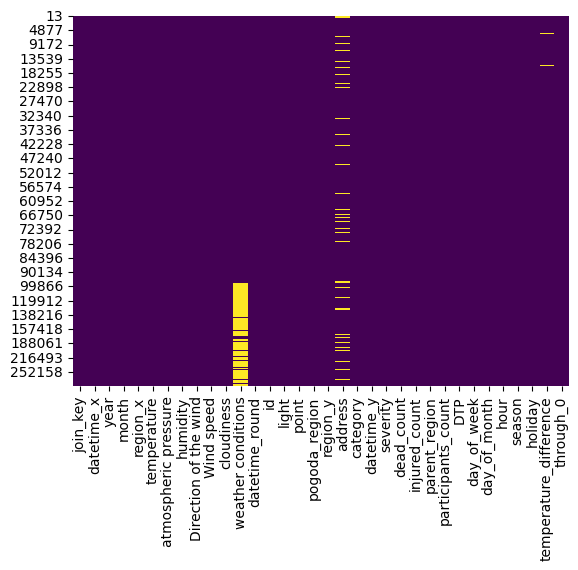

In [73]:
# выводим график пропущенных значений
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

In [74]:
# удаляем строки с нулевыми значениями
df = df.dropna()

In [75]:
pd.set_option('display.max_columns', None)

In [76]:
df.head()

,join_key,datetime_x,year,month,region_x,temperature,atmospheric pressure,humidity,Direction of the wind,Wind speed,cloudiness,weather conditions,datetime_round,id,light,point,pogoda_region,region_y,address,category,datetime_y,severity,dead_count,injured_count,parent_region,participants_count,DTP,day_of_week,day_of_month,hour,season,holiday,temperature_difference,through_0
63,"Восток43132,5",2018-02-01,2018,2,Восток,-8.9,763.3,73.0,ЗЮЗ,1.0,0.00,,2018-02-01 12:00:00,1527810.0,Светлое время суток,"{'lat': 55.4725, 'long': 37.4616}",Восток,Измайлово,"г Москва, ул Первомайская, 4",Столкновение,2018-02-01 11:45:00,Легкий,0.0,1.0,Москва,3.0,1,3,1,12,1,0,-10.2,False
64,"Восток43132,5",2018-02-01,2018,2,Восток,-8.9,763.3,73.0,ЗЮЗ,1.0,0.00,,2018-02-01 12:00:00,1527489.0,Светлое время суток,"{'lat': 55.4811, 'long': 37.4876}",Восток,Северное Измайлово,"г Москва, б-р Сиреневый, 30",Наезд на пешехода,2018-02-01 11:05:00,Легкий,0.0,1.0,Москва,2.0,1,3,1,12,1,0,0.0,False
80,"Восток43862,375",2020-02-01,2020,2,Восток,-0.1,753.7,94.0,"Штиль, безветрие",0.0,0.95,Дымка.,2020-02-01 09:00:00,1572357.0,Светлое время суток,"{'lat': 55.782233, 'long': 37.718822}",Восток,Соколиная гора,"г Москва, пл Семёновская, 1",Столкновение,2020-02-01 08:00:00,Легкий,0.0,1.0,Москва,2.0,1,5,1,9,1,0,1.9,False
81,"Восток43862,375",2020-02-01,2020,2,Восток,-0.1,753.7,94.0,"Штиль, безветрие",0.0,0.95,Дымка.,2020-02-01 09:00:00,1572398.0,Светлое время суток,"{'lat': 55.708527, 'long': 37.896502}",Восток,Косино-Ухтомский,"п Ухтомский, ш Косинское, Красковская",Столкновение,2020-02-01 09:45:00,Легкий,0.0,1.0,Москва,3.0,1,5,1,9,1,0,0.0,False
122,"Восток43525,375",2019-03-01,2019,3,Восток,0.4,738.9,93.0,ССВ,2.0,1.00,Снег непрерывный слабый в срок наблюдения.,2019-03-01 09:00:00,1528404.0,Светлое время суток,"{'lat': 55.715526, 'long': 37.883177}",Восток,Косино-Ухтомский,"п Ухтомский, ул Руднёвка, 9",Наезд на пешехода,2019-03-01 08:24:00,Легкий,0.0,1.0,Москва,2.0,1,4,1,9,1,0,2.8,True


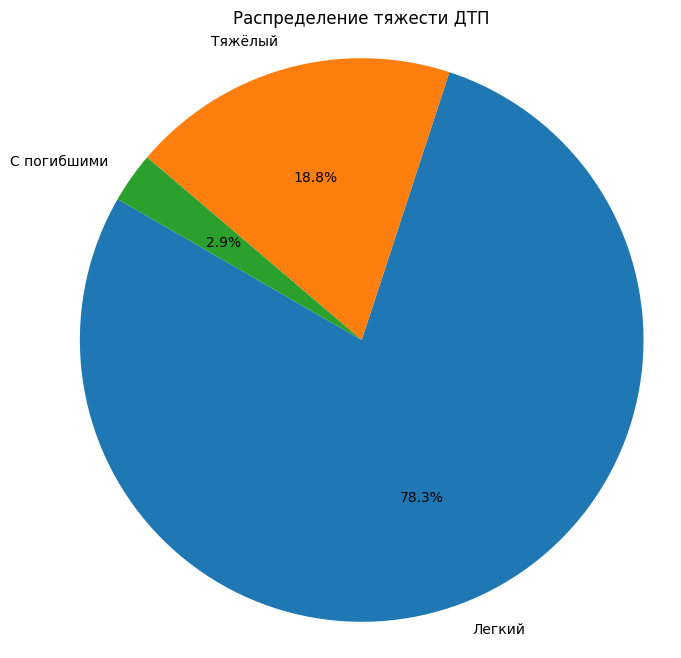

In [77]:
# график распределения тяжести ДПТ
severity_counts = df['severity'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', startangle=150)
plt.title('Распределение тяжести ДТП')
plt.axis('equal')
plt.show()

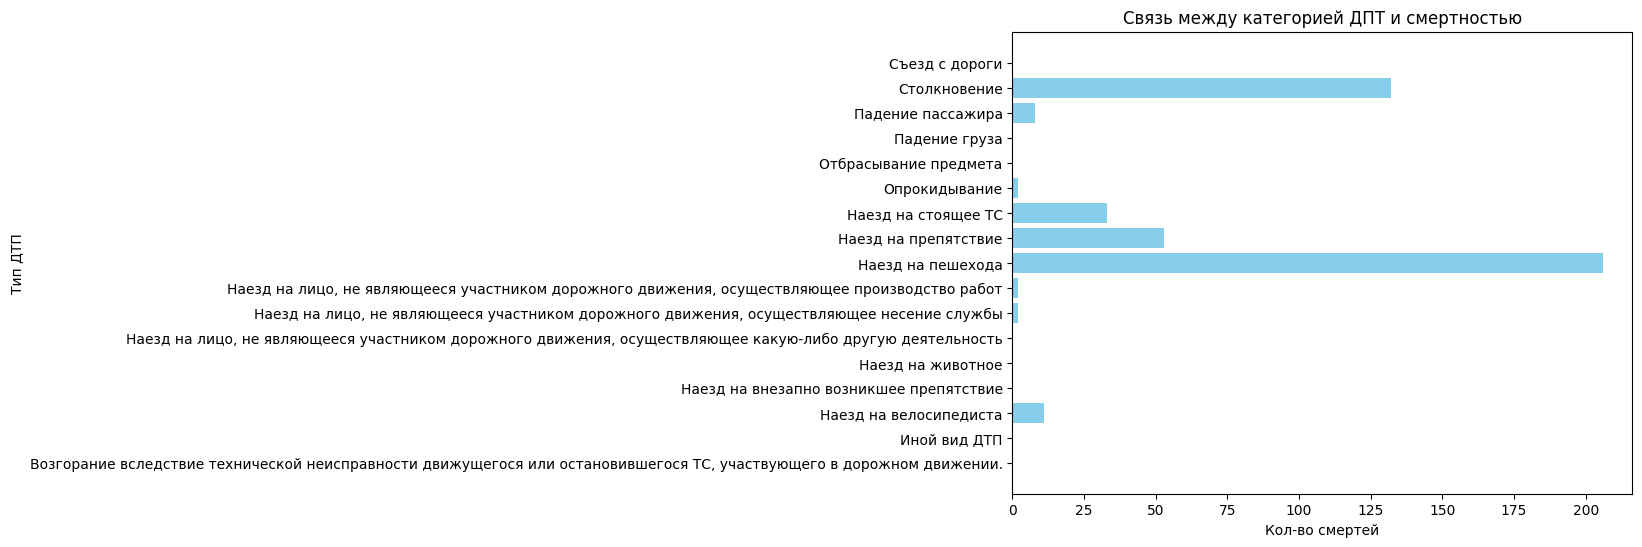

In [78]:
# график связи между категорией ДПТ и смертностью
grouped_data = df.groupby('category')['dead_count'].sum().reset_index()
plt.figure(figsize=(8, 6))
plt.barh(grouped_data['category'], grouped_data['dead_count'], color='skyblue')
plt.title('Связь между категорией ДПТ и смертностью')
plt.xlabel('Кол-во смертей')
plt.ylabel('Тип ДТП')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

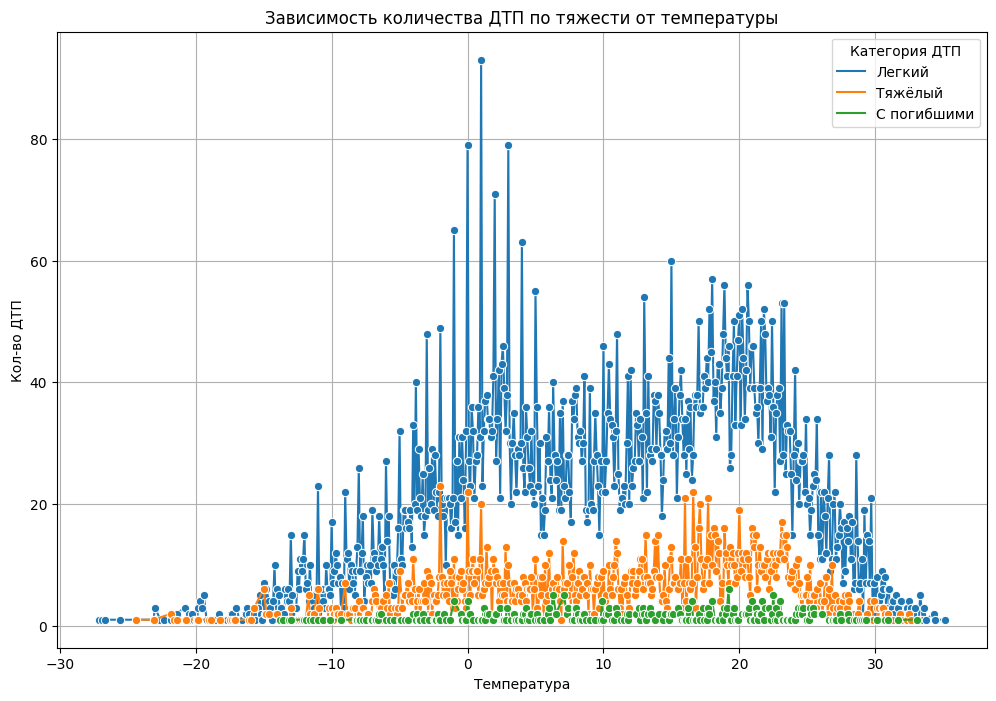

In [79]:
# график зависимости зависимости количества ДТП по тяжести от температуры
plt.figure(figsize=(12, 8))
sns.lineplot(x='temperature', y='DTP', hue='severity', data=df.groupby(['temperature', 'severity'])['DTP'].count().reset_index(), marker='o')
plt.title('Зависимость количества ДТП по тяжести от температуры')
plt.xlabel('Температура')
plt.ylabel('Кол-во ДТП')
plt.grid(True)
plt.legend(title='Категория ДТП')
plt.show()

In [ ]:
# проверка на пропуски
for i in df_copy.columns:
    print(i,df_copy[i].isnull().sum()) ААААААААААААААААААААААААААААААААААААА

In [80]:
# удаление ненужных столбцов и тех, что напрямую связаны с ответом
df_copy = df.copy()
df_copy.drop(columns = ['datetime_x', 'join_key', 'datetime_round','pogoda_region',
                        'light', 'id', 'point', 'region_y', 'address', 'category',
                        'parent_region', 'dead_count', 'injured_count', 'DTP',
                        'participants_count', 'datetime_y'], inplace = True)

In [81]:
# преобразование категориальных данных в дискретные
categorical_columns = ['region_x', 'Direction of the wind', 'severity', 'weather conditions']
label_encoder = LabelEncoder()
for column in categorical_columns:
    df_copy[column] = label_encoder.fit_transform(df_copy[column])
df_copy['through_0'] = df['through_0'].astype(int)

In [82]:
#cat_columns = ['year', 'month', 'temperature', 'atmospheric pressure', 'humidity', 'Wind speed', 'cloudiness',
#               'temperature_difference']
#df_copy[cat_columns] = df_copy[cat_columns].apply(lambda x: pd.factorize(x)[0].astype(np.float64))

In [83]:
df_copy.head()

,year,month,region_x,temperature,atmospheric pressure,humidity,Direction of the wind,Wind speed,cloudiness,weather conditions,severity,day_of_week,day_of_month,hour,season,holiday,temperature_difference,through_0
63,2018,2,0,-8.9,763.3,73.0,5,1.0,0.00,0,0,3,1,12,1,0,-10.2,0
64,2018,2,0,-8.9,763.3,73.0,5,1.0,0.00,0,0,3,1,12,1,0,0.0,0
80,2020,2,0,-0.1,753.7,94.0,12,0.0,0.95,15,0,5,1,9,1,0,1.9,0
81,2020,2,0,-0.1,753.7,94.0,12,0.0,0.95,15,0,5,1,9,1,0,0.0,0
122,2019,3,0,0.4,738.9,93.0,10,2.0,1.00,80,0,4,1,9,1,0,2.8,1


In [84]:
# выделяем фичи и целевую переменную
features = ['year', 'month', 'region_x', 'temperature', 'atmospheric pressure', 'humidity',
            'Direction of the wind', 'Wind speed', 'cloudiness', 'weather conditions',
            'holiday', 'through_0', 'season', 'hour', 'temperature_difference',
            'day_of_week', 'day_of_month']

target = 'severity'

X = df_copy[features]
y = df_copy[target]

In [85]:
# разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42, stratify=y)

In [87]:
# Обучение AutoML на тестовых данных
automl = tpot.TPOTClassifier(population_size = 50 , scoring='f1_macro', verbosity=2, random_state=42, n_jobs=-1, generations = 5)
automl.fit(X_train, y_train)
f1_val = f1_score(y_test, automl.predict(X_test), average='macro')
print(f1_val)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3577887664843011

Generation 2 - Current best internal CV score: 0.3577887664843011

Generation 3 - Current best internal CV score: 0.3596647141463322

Generation 4 - Current best internal CV score: 0.35975399932927904

Generation 5 - Current best internal CV score: 0.3597950734078233

Best pipeline: RandomForestClassifier(StandardScaler(ExtraTreesClassifier(MinMaxScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.45, min_samples_leaf=10, min_samples_split=3, n_estimators=100)), bootstrap=True, criterion=gini, max_features=0.7000000000000001, min_samples_leaf=10, min_samples_split=15, n_estimators=100)
0.35745328649082664


In [94]:
# CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiClass', cat_features=[2, 6, 12])

In [95]:


catboost_model.fit(X, y)

# Предсказание на тестовом наборе
y_pred_catboost = catboost_model.predict(X)

# Оценка производительности с использованием F1-метрики
f1_catboost = f1_score(y, y_pred_catboost, average='weighted')

# Вывод отчета о классификации
print(classification_report(y, y_pred_catboost))

# Вывод F1-метрики
print(f"F1 Score (CatBoost): {f1_catboost}")


0:	learn: 1.0143980	total: 346ms	remaining: 2m 52s
1:	learn: 0.9423963	total: 424ms	remaining: 1m 45s
2:	learn: 0.8841876	total: 504ms	remaining: 1m 23s
3:	learn: 0.8389245	total: 755ms	remaining: 1m 33s
4:	learn: 0.8006574	total: 860ms	remaining: 1m 25s
5:	learn: 0.7687735	total: 1.14s	remaining: 1m 34s
6:	learn: 0.7413653	total: 1.3s	remaining: 1m 31s
7:	learn: 0.7204157	total: 1.52s	remaining: 1m 33s
8:	learn: 0.7010573	total: 1.59s	remaining: 1m 26s
9:	learn: 0.6847243	total: 1.75s	remaining: 1m 25s
10:	learn: 0.6705513	total: 1.94s	remaining: 1m 26s
11:	learn: 0.6579089	total: 2.17s	remaining: 1m 28s
12:	learn: 0.6463662	total: 2.23s	remaining: 1m 23s
13:	learn: 0.6365663	total: 2.32s	remaining: 1m 20s
14:	learn: 0.6280205	total: 2.54s	remaining: 1m 22s
15:	learn: 0.6204908	total: 2.79s	remaining: 1m 24s
16:	learn: 0.6148004	total: 2.81s	remaining: 1m 19s
17:	learn: 0.6089127	total: 3.07s	remaining: 1m 22s
18:	learn: 0.6026221	total: 3.36s	remaining: 1m 25s
19:	learn: 0.5976328	to

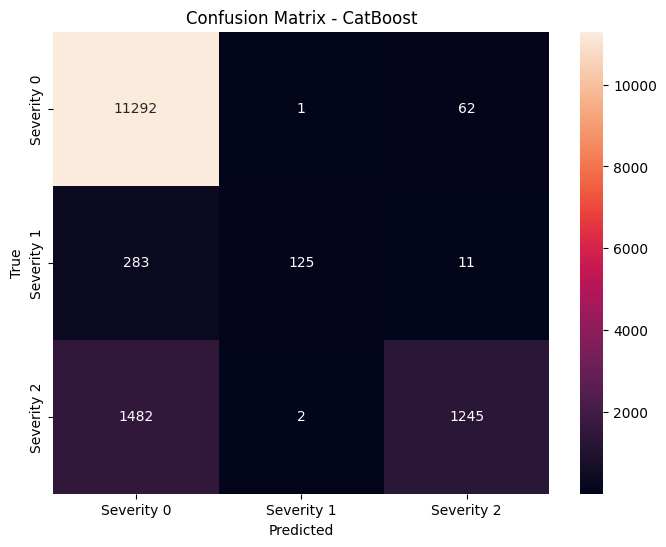

In [99]:
# Получение предсказаний CatBoost на тестовом наборе
y_pred_catboost = catboost_model.predict(X)

# Создание матрицы ошибок
conf_matrix_catboost = confusion_matrix(y, y_pred_catboost)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d",
            xticklabels=["Severity 0", "Severity 1", "Severity 2"],
            yticklabels=["Severity 0", "Severity 1", "Severity 2"])
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

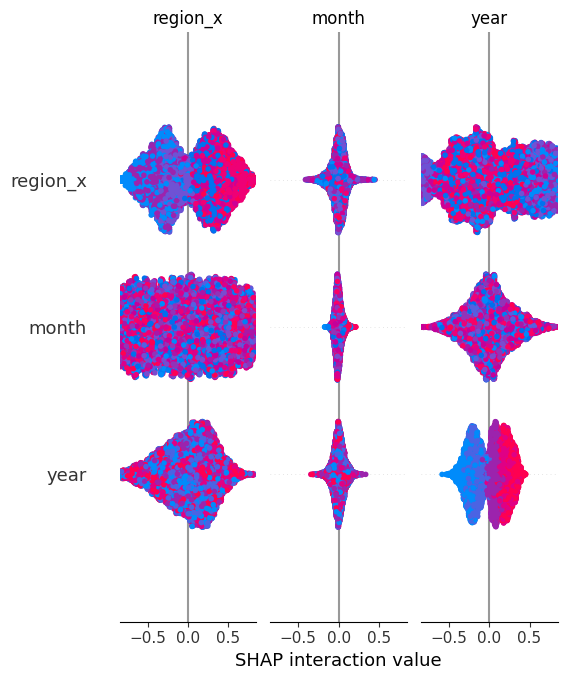

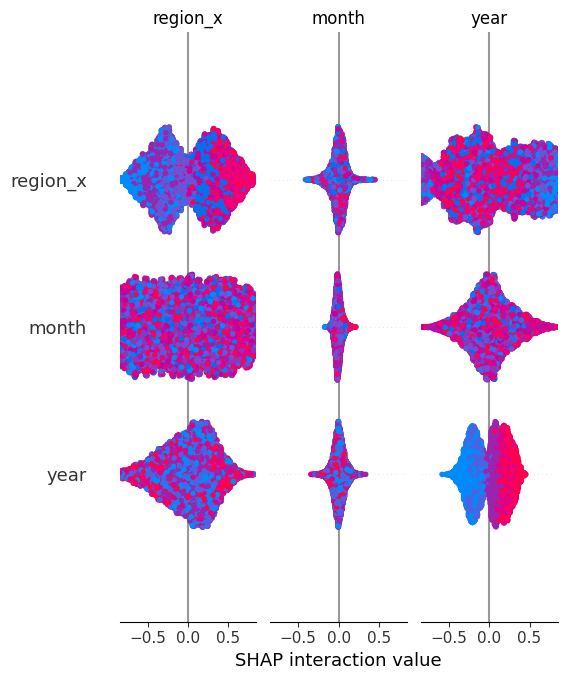

In [104]:
# Создание объекта explainer для CatBoost
explainer = shap.Explainer(catboost_model)

# Расчет значений SHAP
shap_values = explainer.shap_values(X)

# Визуализация влияния каждой фичи
shap.summary_plot(shap_values, X, plot_type="bar")
# Создаем объект Explainer
explainer = shap.Explainer(catboost_model)

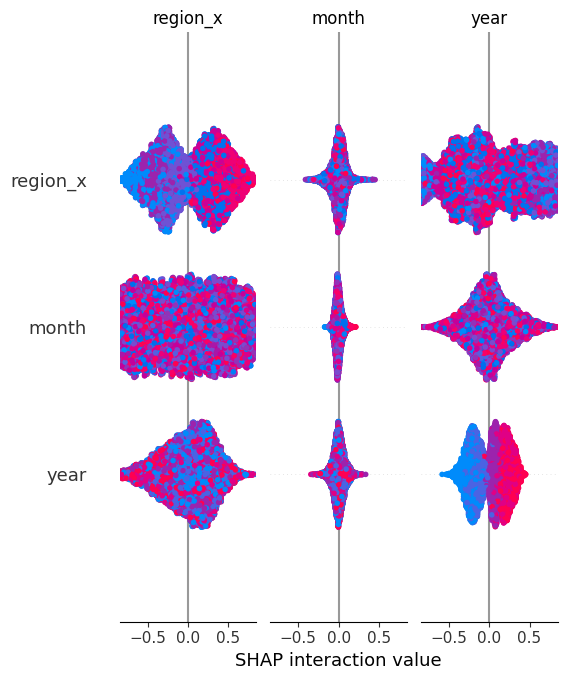

In [108]:
# Создание объекта explainer для CatBoost
explainer = shap.Explainer(catboost_model)

# Расчет значений SHAP
shap_values = explainer.shap_values(X)

# Визуализация влияния каждой фичи
shap.summary_plot(shap_values, X, plot_type="bar")
# Создаем объект Explainer
explainer = shap.Explainer(catboost_model)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

# RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print("RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))
print(f"F1 Score: {f1_rf}\n")

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      6797
           1       0.05      0.00      0.01       252
           2       0.31      0.05      0.09      1653

    accuracy                           0.77      8702
   macro avg       0.38      0.34      0.32      8702
weighted avg       0.67      0.77      0.70      8702

F1 Score: 0.6950561001718286



In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

# GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
print("GradientBoostingClassifier:")
print(classification_report(y_test, y_pred_gb))
print(f"F1 Score: {f1_gb}")

GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      6797
           1       0.00      0.00      0.00       252
           2       0.24      0.01      0.03      1653

    accuracy                           0.77      8702
   macro avg       0.34      0.33      0.30      8702
weighted avg       0.66      0.77      0.69      8702

F1 Score: 0.6867490245845884


In [57]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# XGBoost
xgb_model = XGBClassifier(objective='multi:softmax', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(f"F1 Score (XGBoost): {f1_xgb}")

XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      6797
           1       0.00      0.00      0.00       252
           2       0.29      0.08      0.12      1653

    accuracy                           0.76      8702
   macro avg       0.36      0.34      0.33      8702
weighted avg       0.67      0.76      0.70      8702

F1 Score (XGBoost): 0.6966975534018737
